# Prudential Life Insurance Assessment

An example of the structured data lessons from Lesson 4 on another dataset.

In [238]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from fastai import structured
from fastai.column_data import ColumnarModelData
from fastai.dataset import get_cv_idxs
from sklearn.metrics import cohen_kappa_score
from ml_metrics import quadratic_weighted_kappa
from torch.nn.init import kaiming_uniform, kaiming_normal

In [99]:
PATH = Path('./data/prudential')
PATH.mkdir(exist_ok=True)

## Download dataset

In [6]:
!kaggle competitions download -c prudential-life-insurance-assessment --path={PATH}

  0%|                                               | 0.00/24.9k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 24.9k/24.9k [00:00<00:00, 948kB/s]
 98%|█████████████████████████████████████ | 1.00M/1.02M [00:00<00:00, 1.40MB/s]
100%|██████████████████████████████████████| 1.02M/1.02M [00:00<00:00, 1.40MB/s]
 97%|████████████████████████████████████▋ | 3.00M/3.10M [00:02<00:00, 1.46MB/s]
100%|██████████████████████████████████████| 3.10M/3.10M [00:02<00:00, 1.47MB/s]


In [10]:
for file in os.listdir(PATH):
    if not file.endswith('zip'):
        continue
        
    !unzip -q -d {PATH} {PATH}/{file}

In [135]:
train_df = pd.read_csv(PATH/'train.csv')

In [136]:
train_df.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


Extra feature engineering taken from the forum

In [137]:
train_df['Product_Info_2_char'] = train_df.Product_Info_2.str[0]
train_df['Product_Info_2_num'] = train_df.Product_Info_2.str[1]
train_df['BMI_Age'] = train_df['BMI'] * train_df['Ins_Age']
med_keyword_columns = train_df.columns[train_df.columns.str.startswith('Medical_Keyword_')]
train_df['Med_Keywords_Count'] = train_df[med_keyword_columns].sum(axis=1)
train_df['num_na'] = train_df.apply(lambda x: sum(x.isnull()), 1)

In [102]:
categorical_columns = 'Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41'.split(', ')

In [138]:
categorical_columns += ['Product_Info_2_char', 'Product_Info_2_num']

In [139]:
cont_columns = 'Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5, Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32'.split(', ')

In [140]:
cont_columns += [c for c in train_df.columns if c.startswith('Medical_Keyword_')] + ['BMI_Age', 'Med_Keywords_Count', 'num_na']

In [141]:
train_df[categorical_columns].head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_5,Product_Info_6,Product_Info_7,Employment_Info_2,Employment_Info_3,Employment_Info_5,InsuredInfo_1,...,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Product_Info_2_char,Product_Info_2_num
0,1,D3,10,2,1,1,12,1,3,1,...,3,1,2,2,1,3,3,3,D,3
1,1,A1,26,2,3,1,1,3,2,1,...,1,1,2,2,1,3,3,1,A,1
2,1,E1,26,2,3,1,9,1,2,1,...,3,1,3,2,1,3,3,1,E,1
3,1,D4,10,2,3,1,9,1,3,2,...,3,1,2,2,1,3,3,1,D,4
4,1,D2,26,2,3,1,9,1,2,1,...,3,1,3,2,1,3,3,1,D,2


In [142]:
train_df[cont_columns].head()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,...,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,BMI_Age,Med_Keywords_Count,num_na
0,0.076923,0.641791,0.581818,0.148536,0.323008,0.028,0.0,NaN,0.000667,NaN,...,0,0,0,0,0,0,0,0.207304,0,6
1,0.076923,0.059701,0.600000,0.131799,0.272288,0.000,0.0,0.0018,0.000133,0.188406,...,0,0,0,0,0,0,0,0.016256,0,5
2,0.076923,0.029851,0.745455,0.288703,0.428780,0.030,0.0,0.0300,NaN,0.304348,...,0,0,0,0,0,0,0,0.012799,0,7
3,0.487179,0.164179,0.672727,0.205021,0.352438,0.042,0.0,0.2000,NaN,0.420290,...,0,0,0,0,0,0,0,0.057863,1,7
4,0.230769,0.417910,0.654545,0.234310,0.424046,0.027,0.0,0.0500,NaN,0.463768,...,0,0,0,0,0,0,0,0.177213,0,8


In [143]:
train_df = train_df[categorical_columns + cont_columns + ['Response']]

In [144]:
len(train_df.columns)

132

### Convert to categorical

In [145]:
for col in categorical_columns:
    train_df[col] = train_df[col].astype('category').cat.as_ordered()

In [146]:
train_df['Product_Info_1'].dtype

CategoricalDtype(categories=[1, 2], ordered=True)

In [147]:
train_df.shape

(59381, 132)

### Numericalise and process DataFrame

In [148]:
df, y, nas, mapper = structured.proc_df(train_df, 'Response', do_scale=True)
y = y - 1

In [149]:
num_targets = len(set(y))

### Create ColumnData object (instead of ImageClassifierData)

In [150]:
cv_idx = get_cv_idxs(len(df))

In [151]:
cv_idx

array([41952, 28556,  7984, ..., 39401,  9440, 31775])

In [180]:
model_data = ColumnarModelData.from_data_frame(
    PATH, cv_idx, df, y, cat_flds=categorical_columns, is_reg=False)

In [181]:
model_data.trn_ds[0][0].shape[0] + model_data.trn_ds[0][1].shape[0]

144

In [182]:
model_data.trn_ds[0][1].shape

(82,)

### Get embedding sizes

The formula Jeremy uses for getting embedding sizes is: cardinality / 2 (maxed out at 50).

We reproduce that below:

In [239]:
categorical_column_sizes = [
    (c, len(train_df[c].cat.categories) + 1) for c in categorical_columns]

In [240]:
categorical_column_sizes[:5]

[('Product_Info_1', 3),
 ('Product_Info_2', 20),
 ('Product_Info_3', 35),
 ('Product_Info_5', 3),
 ('Product_Info_6', 3)]

In [241]:
embedding_sizes = [(c, min(50, (c+1)//2)) for _, c in categorical_column_sizes]

In [242]:
embedding_sizes[:5]

[(3, 2), (20, 10), (35, 18), (3, 2), (3, 2)]

In [243]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)

In [244]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_sizes, num_cont):
        super().__init__()
        
        embedding_layers = []
        for size, dim in emb_sizes:
            embedding_layers.append(
                nn.Embedding(
                    num_embeddings=size, embedding_dim=dim))
        
        self.embeddings = nn.ModuleList(embedding_layers)
        for emb in self.embeddings: emb_init(emb)
        self.embedding_dropout = nn.Dropout(0.04)
        
        self.batch_norm_cont = nn.BatchNorm1d(num_cont)
        
        num_emb = sum(e.embedding_dim for e in self.embeddings)
        
        self.fc1 = nn.Linear(
            in_features=num_emb + num_cont,
            out_features=1000)
        kaiming_normal(self.fc1.weight.data)
        self.dropout_fc1 = nn.Dropout(p=0.001)
        self.batch_norm_fc1 = nn.BatchNorm1d(1000)
        
        self.fc2 = nn.Linear(
            in_features=1000,
            out_features=500)
        kaiming_normal(self.fc2.weight.data)
        self.dropout_fc2 = nn.Dropout(p=0.01)
        self.batch_norm_fc2 = nn.BatchNorm1d(500)
        
        self.output_fc = nn.Linear(
            in_features=500,
            out_features=num_targets
        )
        kaiming_normal(self.output_fc.weight.data)
        self.softmax = nn.LogSoftmax()
        
        
    def forward(self, categorical_input, continuous_input):
        # Add categorical embeddings together
        categorical_embeddings = [e(categorical_input[:,i]) for i, e in enumerate(self.embeddings)]
        categorical_embeddings = torch.cat(categorical_embeddings, 1)
        categorical_embeddings_dropout = self.embedding_dropout(categorical_embeddings)
             
        # Batch normalise continuos vars
        continuous_input_batch_norm = self.batch_norm_cont(continuous_input)
        
        # Create a single vector
        x = torch.cat([
            categorical_embeddings_dropout, continuous_input_batch_norm
        ], dim=1)
        
        # Fully-connected layer 1
        fc1_output = self.fc1(x)
        fc1_relu_output = F.relu(fc1_output)
        fc1_dropout_output = self.dropout_fc1(fc1_relu_output)
        fc1_batch_norm = self.batch_norm_fc1(fc1_dropout_output)
        
        # Fully-connected layer 2
        fc2_output = self.fc2(fc1_batch_norm)
        fc2_relu_output = F.relu(fc2_output)
        fc2_dropout_output = self.dropout_fc2(fc2_relu_output)
        fc2_batch_norm = self.batch_norm_fc2(fc2_dropout_output)
        
        output = self.output_fc(fc2_batch_norm)
        output = self.softmax(output)
        
        return output

In [245]:
num_cont = len(df.columns) - len(categorical_columns)

model = MixedInputModel(
    embedding_sizes,
    num_cont
)

In [246]:
model

MixedInputModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(20, 10)
    (2): Embedding(35, 18)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(4, 2)
    (6): Embedding(37, 19)
    (7): Embedding(3, 2)
    (8): Embedding(3, 2)
    (9): Embedding(4, 2)
    (10): Embedding(3, 2)
    (11): Embedding(12, 6)
    (12): Embedding(3, 2)
    (13): Embedding(3, 2)
    (14): Embedding(3, 2)
    (15): Embedding(3, 2)
    (16): Embedding(3, 2)
    (17): Embedding(4, 2)
    (18): Embedding(4, 2)
    (19): Embedding(4, 2)
    (20): Embedding(4, 2)
    (21): Embedding(4, 2)
    (22): Embedding(4, 2)
    (23): Embedding(4, 2)
    (24): Embedding(580, 50)
    (25): Embedding(4, 2)
    (26): Embedding(3, 2)
    (27): Embedding(4, 2)
    (28): Embedding(4, 2)
    (29): Embedding(4, 2)
    (30): Embedding(4, 2)
    (31): Embedding(4, 2)
    (32): Embedding(4, 2)
    (33): Embedding(4, 2)
    (34): Embedding(4, 2)
    (35): Embedding(4, 2)
    (36): Embedding

In [247]:
from fastai.column_data import StructuredLearner

In [248]:
def weighted_kappa_metric(probs, y):
    return quadratic_weighted_kappa(np.argmax(probs, axis=1), y)

In [249]:
learner = StructuredLearner.from_model_data(model, model_data, metrics=[weighted_kappa_metric])

In [250]:
learner.lr_find()

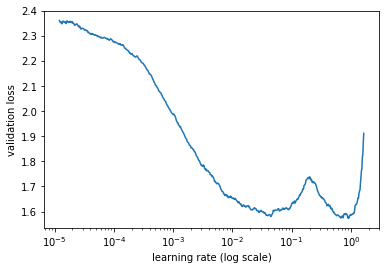

In [251]:
learner.sched.plot()

In [252]:
learner.fit(0.001, 3)

epoch      trn_loss   val_loss   weighted_kappa_metric       
    0      1.510729   1.496952   0.440844  
    1      1.392997   1.428711   0.466718                    
    2      1.323397   1.367037   0.506537                    


[array([1.36704]), 0.5065372317934015]

In [253]:
learner.fit(0.005, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   weighted_kappa_metric       
    0      1.28631    1.322071   0.518739  
    1      1.250283   1.311934   0.504082                    
    2      1.202491   1.322111   0.522633                    
    3      1.227511   1.378858   0.522038                    
    4      1.190217   1.36488    0.528409                    
    5      1.136912   1.39515    0.513832                    
    6      1.130117   1.522553   0.522189                    


[array([1.52255]), 0.5221893232037057]

In [254]:
learner.fit(0.005, 5, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   weighted_kappa_metric       
    0      1.145026   1.364807   0.521691  
    1      1.151091   1.281678   0.52916                     
    2      1.100153   1.289373   0.520821                    
    3      1.156173   1.337169   0.508556                    
    4      1.098961   1.365759   0.528104                    
    5      1.03615    1.339479   0.532855                    
    6      1.000932   1.419953   0.530932                     
    7      1.117512   1.344897   0.528901                    
    8      1.110349   1.36162    0.542422                    
    9      1.028235   1.456376   0.528784                     
    10     1.004464   3.510088   0.514979                     
    11     0.942656   1.712703   0.533551                     
    12     0.898058   1.43448    0.533633                     
    13     0.857682   1.414549   0.531477                     
    14     0.822834   1.583858   0.526679                    
    15     1.003029 

[array([1.80203]), 0.5212841305880999]

There's either a bug in my implementation, or a NN doesn't do that well at this problem.